In [30]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [128]:
def load_data(dataset_path, sequence_length=60, prediction_steps=5, ratio_of_data=1.0):
    max_values = ratio_of_data * 2075259  # 2075259 is the total number of measurements from Dec 2006 to Nov 2010

    # Load data from file
    with open(dataset_path) as file:
        data_file = csv.reader(file, delimiter=";")
        power_consumption = []
        number_of_values = 0
        for line in data_file:
            try:
                power_consumption.append(float(line[2]))
                number_of_values += 1
            except ValueError:
                pass
            if number_of_values >= max_values:  # limit data to be considered by model according to max_values
                break

    print('Loaded data from csv.')
    windowed_data = []
    # Format data into rolling window sequences
    for index in range(len(power_consumption) - sequence_length):  # for e.g: index=0 => 123, index=1 => 234 etc.
        windowed_data.append(power_consumption[index: index + sequence_length])
    windowed_data = np.array(windowed_data)  # shape (number of samples, sequence length)

    # Center data
    data_mean = windowed_data.mean()
    windowed_data -= data_mean
    print('Center data so mean is zero (subtract each data point by mean of value: ', data_mean, ')')
    print('Data  : ', windowed_data.shape)

    # Split data into training and testing sets
    train_set_ratio = 0.9
    row = int(round(train_set_ratio * windowed_data.shape[0]))
    train = windowed_data[:row, :]
    x_train = train[:, :-prediction_steps]  # remove last prediction_steps from train set
    y_train = train[:, -prediction_steps:]  # take last prediction_steps from train set
    x_test = windowed_data[row:, :-prediction_steps]
    y_test = windowed_data[row:, -prediction_steps:]  # take last prediction_steps from test set

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test, data_mean]

In [131]:
max_values =  2075259
with open(dataset_path) as file:
        data_file = csv.reader(file, delimiter=";")
        power_consumption = []
        number_of_values = 0
        for line in data_file:
            try:
                power_consumption.append(float(line[2]))
                number_of_values += 1
            except ValueError:
                pass
            if number_of_values >= max_values:  # limit data to be considered by model according to max_values
                break

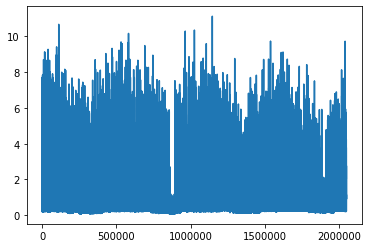

In [22]:
plt.plot(power_consumption)

In [23]:
len(power_consumption)

2049280

In [24]:
dataset_path = 'data/household_power_consumption.txt'

In [25]:
x_train, y_train,x_test,y_test,data_mean = load_data(dataset_path, sequence_length=60, prediction_steps=5, ratio_of_data=1.0)

Loaded data from csv.
Center data so mean is zero (subtract each data point by mean of value:  1.0915705613030047 )
Data  :  (2049220, 60)


In [26]:
import time
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential, load_model
from data import load_data
from numpy.random import seed
seed(1234)  # seed random numbers for Keras
from tensorflow import set_random_seed
set_random_seed(2)  # seed random numbers for Tensorflow backend
from plot import plot_predictions


def build_model(prediction_steps):
    model = Sequential()
    layers = [1, 75, 100, prediction_steps]
    model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))  # add first layer
    model.add(Dropout(0.2))  # add dropout for first layer
    model.add(LSTM(layers[2], return_sequences=False))  # add second layer
    model.add(Dropout(0.2))  # add dropout for second layer
    model.add(Dense(layers[3]))  # add output layer
    model.add(Activation('linear'))  # output layer with linear activation
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print('Compilation Time : ', time.time() - start)
    return model


def run_lstm(model, sequence_length, prediction_steps):
    data = None
    global_start_time = time.time()
    epochs = 1
    ratio_of_data = 1  # ratio of data to use from 2+ million data points
    path_to_dataset = 'data/household_power_consumption.txt'

    if data is None:
        print('Loading data... ')
        x_train, y_train, x_test, y_test, result_mean = load_data(path_to_dataset, sequence_length,
                                                                  prediction_steps, ratio_of_data)
    else:
        x_train, y_train, x_test, y_test = data

    print('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model(prediction_steps)
        try:
            model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.05)
            predicted = model.predict(x_test)
            # predicted = np.reshape(predicted, (predicted.size,))
            model.save('LSTM_power_consumption_model.h5')  # save LSTM model
        except KeyboardInterrupt:  # save model if training interrupted by user
            print('Duration of training (s) : ', time.time() - global_start_time)
            model.save('LSTM_power_consumption_model.h5')
            return model, y_test, 0
    else:  # previously trained mode is given
        print('Loading model...')
        predicted = model.predict(x_test)
    plot_predictions(result_mean, prediction_steps, predicted, y_test, global_start_time)

    return None

Using TensorFlow backend.
C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16


Loading data... 
Loaded data from csv.
Center data so mean is zero (subtract each data point by mean of value:  1.091607820345784 )
Data  :  (2049270, 10)

Data Loaded. Compiling...

Compilation Time :  0.01795172691345215

Train on 1752125 samples, validate on 92218 samples
Epoch 1/1
1752125/1752125 [==============================] - 137s 78us/step - loss: 0.1915 - val_loss: 0.1547
Plotting predictions...


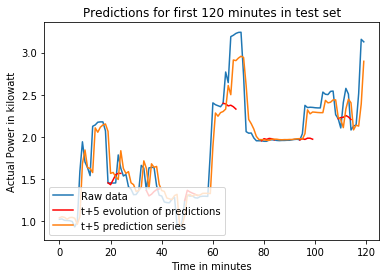

Duration of training (s) :  156.01106095314026


In [27]:
from keras.models import load_model
from lstm import run_lstm

if __name__ == '__main__':
    loading_model = False
    if loading_model:
        model = load_model('LSTM_power_consumption_model.h5')
    else:
        model = None
    sequence_length = 10  # number of past minutes of data for model to consider
    prediction_steps = 5  # number of future minutes of data for model to predict
    run_lstm(model, sequence_length, prediction_steps)


### Applying Same Model for solar Energy Forecasting

In [85]:
j = pd.read_csv('solar_data/JULY_B_2018.csv')
a = pd.read_csv('solar_data/AUG_B_2018.csv')
s = pd.read_csv('solar_data/SEP_B_2018.csv')
o = pd.read_csv('solar_data/OCT_B_2018.csv')
n = pd.read_csv('solar_data/NOV_B_2018.csv')
d = pd.read_csv('solar_data/DEC_B_2018.csv')
jan = pd.read_csv('solar_data/JAN_B_2019.csv')
fab = pd.read_csv('solar_data/FAB_B_2019.csv')
m = pd.read_csv('solar_data/MAR_B_2018.csv')
ma = pd.read_csv('solar_data/APR_B_2018.csv')
my = pd.read_csv('solar_data/MAY_B_2018.csv')
ju = pd.read_csv('solar_data/JUNE_B_2018.csv')
mar2019 = pd.read_csv('solar_data/MAR_B_2019.csv')

In [86]:
ff3 = m.T.iloc[21:55]
ff4 = ma.T.iloc[21:55] # july data
ff5 = my.T.iloc[21:55] # august data
ff6 = ju.T.iloc[21:55] # september data
ff7 = j.T.iloc[21:55] # October data
ff8 = a.T.iloc[21:55] # november data
ff9 = s.T.iloc[21:55] # december data
ff10 = o.T.iloc[21:55] # january data
ff11 = n.T.iloc[21:55] # february data
ff12 = d.T.iloc[21:55]    # march data
ff1 = jan.T.iloc[21:55] # january data
ff2 = fab.T.iloc[21:55] #february
ffx = mar2019

In [90]:
d = pd.concat([ff3,ff4,ff5,ff6,ff7,ff8,ff9,ff10,ff11,ff12,ff1,ff2],axis=1)

In [96]:
ff3 = d.T

In [97]:
data = []
for d in ff3.values:
    for dx in d:
        data.append(dx)

In [98]:
len(data)

11798

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt


# plot results


def plot_predictions(result_mean, prediction_steps, predicted, y_test, global_start_time):
    try:
        test_hours_to_plot = 2
        t0 = 20  # time to start plot of predictions
        skip = 15  # skip prediction plots by specified minutes
        print('Plotting predictions...')
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(y_test[:test_hours_to_plot * 60, 0] + result_mean, label='Raw data')  # plot actual test series

        # plot predicted values from t0 to t0+prediction_steps
        plt.plot(np.arange(t0 - 1, t0 + prediction_steps),
                 np.insert(predicted[t0, :], 0, y_test[t0 - 1, 0]) + result_mean,
                 color='red', label='t+{0} evolution of predictions'.format(prediction_steps))
        for i in range(t0, test_hours_to_plot * 60, skip):
            t0 += skip
            if t0 + prediction_steps > test_hours_to_plot * 60:  # check plot does not exceed boundary
                break
            plt.plot(np.arange(t0 - 1, t0 + prediction_steps),
                     np.insert(predicted[t0, :], 0, y_test[t0 - 1, 0]) + result_mean, color='red')

        # plot predicted value of t+prediction_steps as series
        plt.plot(predicted[:test_hours_to_plot * 60, prediction_steps - 1] + result_mean,
                 label='t+{0} prediction series'.format(prediction_steps))

        plt.legend(loc='lower left')
        plt.ylabel('Actual Power in kilowatt')
        plt.xlabel('Time in minutes')
        plt.title('Predictions for first {0} minutes in test set'.format(test_hours_to_plot * 60))
        plt.show()
    except Exception as e:
        print(str(e))
    print('Duration of training (s) : ', time.time() - global_start_time)

    return None

In [99]:
def load_data1(power_consumption, sequence_length=60, prediction_steps=5, ratio_of_data=1.0):
    max_values = 960#ratio_of_data * 2075259  # 2075259 is the total number of measurements from Dec 2006 to Nov 2010

    # Load data from file
    #with open(dataset_path) as file:
    #    data_file = csv.reader(file, delimiter=";")
    #    power_consumption = []
    #    number_of_values = 0
    #    for line in data_file:
    #        try:
    #            power_consumption.append(float(line[2]))
    #            number_of_values += 1
    #        except ValueError:
    #            pass
    #        if number_of_values >= max_values:  # limit data to be considered by model according to max_values
    #            break

    print("Total Number of Points in the Dataset:",len(power_consumption))
    print('Loaded data from csv.')
    windowed_data = []
    # Format data into rolling window sequences
    for index in range(len(power_consumption) - sequence_length):  # for e.g: index=0 => 123, index=1 => 234 etc.
        windowed_data.append(power_consumption[index: index + sequence_length])
    windowed_data = np.array(windowed_data)  # shape (number of samples, sequence length)

    # Center data
    data_mean = windowed_data.mean()
    windowed_data -= data_mean
    print('Center data so mean is zero (subtract each data point by mean of value: ', data_mean, ')')
    print('Data  : ', windowed_data.shape)

    # Split data into training and testing sets
    train_set_ratio = 0.9
    row = int(round(train_set_ratio * windowed_data.shape[0]))
    train = windowed_data[:row, :]
    x_train = train[:, :-prediction_steps]  # remove last prediction_steps from train set
    y_train = train[:, -prediction_steps:]  # take last prediction_steps from train set
    x_test = windowed_data[row:, :-prediction_steps]
    y_test = windowed_data[row:, -prediction_steps:]  # take last prediction_steps from test set

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test, data_mean]

In [100]:
x_train, y_train, x_test, y_test, result_mean = load_data1(data,10,5,1)

Total Number of Points in the Dataset: 11798
Loaded data from csv.
Center data so mean is zero (subtract each data point by mean of value:  5.892779190702409 )
Data  :  (11788, 10)


In [112]:
import time
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential, load_model
from data import load_data
from numpy.random import seed
seed(1234)  # seed random numbers for Keras
from tensorflow import set_random_seed
set_random_seed(2)  # seed random numbers for Tensorflow backend
from plot import plot_predictions


def build_model(prediction_steps):
    model = Sequential()
    layers = [1, 75, 100, prediction_steps]
    model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))  # add first layer
    model.add(Dropout(0.2))  # add dropout for first layer
    model.add(LSTM(layers[2], return_sequences=False))  # add second layer
    model.add(Dropout(0.2))  # add dropout for second layer
    model.add(Dense(layers[3]))  # add output layer
    model.add(Activation('linear'))  # output layer with linear activation
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print('Compilation Time : ', time.time() - start)
    return model


def run_lstm1(model, sequence_length, prediction_steps):
    global_start_time = time.time()
    epochs = 1
    ratio_of_data = 1  # ratio of data to use from 2+ million data points
    #path_to_dataset = 'data/household_power_consumption.txt'

    #if data is not None:
    print('Loading data... ')
    x_train, y_train, x_test, y_test, result_mean = load_data1(data,sequence_length,prediction_steps, ratio_of_data)
    #else:
    #    x_train, y_train, x_test, y_test = data

    print('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model(prediction_steps)
        try:
            model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.05)
            predicted = model.predict(x_test)
            # predicted = np.reshape(predicted, (predicted.size,))
            model.save('LSTM_power_consumption_model.h5')  # save LSTM model
        except KeyboardInterrupt:  # save model if training interrupted by user
            print('Duration of training (s) : ', time.time() - global_start_time)
            model.save('LSTM_power_consumption_model.h5')
            return model, y_test, 0
    else:  # previously trained mode is given
        print('Loading model...')
        predicted = model.predict(x_test)
    plot_predictions(result_mean, prediction_steps, predicted, y_test, global_start_time)

    return model

Loading data... 
Total Number of Points in the Dataset: 11798
Loaded data from csv.
Center data so mean is zero (subtract each data point by mean of value:  5.892779190702409 )
Data  :  (11788, 10)

Data Loaded. Compiling...

Compilation Time :  0.018949270248413086
Train on 10078 samples, validate on 531 samples
Epoch 1/1
10078/10078 [==============================] - 3s 291us/step - loss: 6.6257 - val_loss: 2.0651
Plotting predictions...


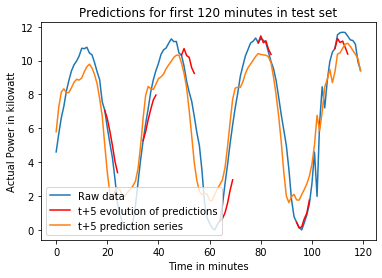

Duration of training (s) :  8.335840702056885


In [125]:
from keras.models import load_model
from lstm import run_lstm

if __name__ == '__main__':
    loading_model = False
    #if loading_model:
    #    model = load_model('LSTM_power_consumption_model.h5')
    #else:
    model = None
    sequence_length = 10  # number of past minutes of data for model to consider
    prediction_steps = 5  # number of future minutes of data for model to predict
    model = run_lstm1(model, sequence_length, prediction_steps)
